In [37]:
import jieba
import os
import pickle
import pandas as pd
import re
import copy
import numpy as np
from functools import reduce
from datetime import datetime, timedelta
from sklearn.cluster import KMeans, MiniBatchKMeans,DBSCAN
from pymongo import MongoClient
import pprint
from sklearn.metrics.pairwise import linear_kernel,cosine_similarity
import jieba.posseg as pseg
import gensim
from gensim import corpora,models

In [106]:
# with open("Events_eps0.7_5days_everywords","rb") as fp:
#     Events = pickle.load(fp)
with open("Events_eps0.7_5days_500topics","rb") as fp:
    Events = pickle.load(fp)
    

In [107]:
# with open("Events_eps0.7_5days","rb") as fp:
#     Events = pickle.load(fp)

In [108]:
# valid
with open("Valid_events_eps0.7_5days_500topics","rb") as fp:
    Valid_events = pickle.load(fp)
# with open("Valid_events_eps0.7_5days_everywords","rb") as fp:
#     Valid_events = pickle.load(fp)
# with open("Valid_events_eps0.7_5days","rb") as fp:
#     Valid_events = pickle.load(fp)

In [109]:
X = Events.copy()
X = X.drop("_id", 1)
# X.insert(0,"org_event",value = list(X.index))
X.drop(["diff","dmax","dmin","org_indexes","subtag","tag"], axis = 1, inplace = True)
# X.drop(["diff","dmax","dmin","org_indexes","subtag","tag"], axis = 1, inplace = True)
# X.insert(0,"org_event",value = list(X.index))
VX = Valid_events.copy()
VX = VX.drop("_id",1)
VX.drop(["diff","dmax","dmin","org_indexes","subtag","tag"], axis = 1, inplace = True)

In [110]:
y = Events["diff"]
y_temp = y.copy()
# cata_y = np.array(list(y_temp))
cata_y = y_temp
# cata_y = pd.cut(cata_y,[-np.inf,1,3,8,13,np.inf],labels = [0,1,2,3,4])
# cata_y = pd.cut(cata_y,[-np.inf,1,5,8,13,np.inf],labels = [0,1,2,3,4])
# cata_y = pd.cut(cata_y,[-np.inf,1,10,20,np.inf],labels = [0,1,2,3])
# cata_y = pd.cut(cata_y,[-np.inf,1,np.inf],labels = [0,1])
# cata_y = pd.cut(cata_y,[-np.inf,1,10,np.inf],labels = [0,1,2])
cata_y = pd.cut(cata_y,[-np.inf,1,3,10,np.inf],labels = [0,1,2,3])
# cata_y = pd.cut(cata_y,[-np.inf,1,8,15,np.inf],labels = [0,1,2,3])
cata_y
Events["diff"]=cata_y
y = Events["diff"]

In [111]:
Vy = Valid_events["diff"]
Vy_temp = Vy.copy()
# cata_Vy = np.array(list(Vy_temp))
cata_Vy = Vy_temp
# cata_Vy = pd.cut(cata_Vy,[-np.inf,1,3,8,13,np.inf],labels = [0,1,2,3,4])
# cata_Vy = pd.cut(cata_Vy,[-np.inf,1,5,8,13,np.inf],labels = [0,1,2,3,4])
# cata_Vy = pd.cut(cata_Vy,[-np.inf,1,10,20,np.inf],labels = [0,1,2,3])
# cata_Vy = pd.cut(cata_y,[-np.inf,1,10,np.inf],labels = [0,1,2])
cata_Vy = pd.cut(cata_y,[-np.inf,1,3,10,np.inf],labels = [0,1,2,3])
# cata_Vy = pd.cut(cata_Vy,[-np.inf,1,8,15,np.inf],labels = [0,1,2,3])
Valid_events["diff"] = cata_Vy
Vy = Valid_events["diff"]


In [112]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X, y)
# imb = ros.fit(X,y)
# X_resampled, y_resampled = imb.sample(X,y)
print(sorted(Counter(y_resampled).items()))

[(0, 20639), (1, 20639), (2, 20639), (3, 20639)]


In [113]:
# import itertools
# X_remake = []
# for i in X_resampled:
#     print(i[0])
#     X_remake.append(i[0])
# X_resampled

In [114]:
VX.head(1)

,hundred_billion,hundred_million,ten_million,million,hundred_thousand,姚文智,蔡正元,侯友宜,盧秀燕,江啟臣,...,topic_490,topic_491,topic_492,topic_493,topic_494,topic_495,topic_496,topic_497,topic_498,topic_499
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0


In [115]:
X.head(1)

,hundred_billion,hundred_million,ten_million,million,hundred_thousand,姚文智,蔡正元,侯友宜,盧秀燕,江啟臣,...,topic_490,topic_491,topic_492,topic_493,topic_494,topic_495,topic_496,topic_497,topic_498,topic_499
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [158]:
len(y)

20806

In [159]:
len(Vy)

228

#######################################SVR#####################################

In [44]:
from sklearn.svm import SVR
import numpy as np
from sklearn.model_selection import train_test_split
X
y = Events["diff"]
Vy = Valid_events["diff"]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

In [15]:
clf = SVR(C=1,epsilon=0.05,gamma =0.9 )
clf.fit(X_train, y_train) 

SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.05, gamma=0.9,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [95]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

y_pred = clf.predict(X_train)

print('MSE train: %.3f' % (
        mean_squared_error(y_train, y_pred)))
print('R^2 train: %.3f' % (
        r2_score(y_train, y_pred)))

NameError: name 'clf' is not defined

In [17]:
y_pred = clf.predict(X_test)

print('MSE test: %.3f' % (
        mean_squared_error(y_test, y_pred)))
print('R^2 tset: %.3f' % (
        r2_score(y_test, y_pred)))

MSE test: 0.332
R^2 tset: 0.012


In [18]:
# valid

y_pred = clf.predict(X)

print('MSE train: %.3f' % (
        mean_squared_error(y, y_pred)))
print('R^2 train: %.3f' % (
        r2_score(y, y_pred)))

y_pred = clf.predict(VX)

print('MSE train: %.3f' % (
        mean_squared_error(Vy, y_pred)))
print('R^2 train: %.3f' % (
        r2_score(Vy, y_pred)))

MSE train: 0.264
R^2 train: 0.185
MSE train: 0.148
R^2 train: -0.001


######################Adaptive Classifier###########################

In [158]:
from sklearn.ensemble import AdaBoostClassifier

       #############Resample##########

In [329]:
ADBC = AdaBoostClassifier(n_estimators=50)
ADBC.fit(X, y) 

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [330]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
y_pred = ADBC.predict(X)
print("Accuracy:%.2f" %accuracy_score(y,y_pred))
print('MSE test: %.3f' % (
        mean_squared_error(y, y_pred)))
print('R^2 tset: %.3f' % (
        r2_score(y, y_pred)))

Accuracy:0.01
MSE test: 0.989
R^2 tset: -98.185


In [186]:
with open("AdaBoostClassifier1_3_8_13","rb") as f:
    ADBC = pickle.load(f)

In [137]:
# with open("AdaBoostClassifier1_3_10","wb") as f:
#     pickle.dump(ADBC,f)

In [131]:
ADBC = AdaBoostClassifier(n_estimators=50)
ADBC.fit(X_resampled, y_resampled) 

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [187]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
y_pred = ADBC.predict(X_resampled)
print("Accuracy:%.2f" %accuracy_score(y_resampled,y_pred))
print('MSE test: %.3f' % (
        mean_squared_error(y_resampled, y_pred)))
print('R^2 tset: %.3f' % (
        r2_score(y_resampled, y_pred)))

Accuracy:0.58
MSE test: 1.018
R^2 tset: 0.491


In [188]:
Vy_pred = ADBC.predict(VX)
Vy_pred
print("Accuracy:%.2f" %accuracy_score(Vy,Vy_pred))
print('MSE test: %.3f' % (
        mean_squared_error(Vy, Vy_pred)))
print('R^2 tset: %.3f' % (
        r2_score(Vy, Vy_pred)))

Accuracy:0.03
MSE test: 3.746
R^2 tset: -171.159


In [148]:
result = Valid_events.copy()
result.insert(loc=1, column='valid_result', value=Vy_pred)
result

,_id,valid_result,diff,dmax,dmin,org_indexes,subtag,tag,hundred_billion,hundred_million,...,學一學,破片,菠菜,頻射,樟木,太差,常卡,因想,會站,奉公守法
0,"{'tag': 0, 'subtag': 0}",1,1,2018-01-11,2018-01-06,"[204, 187, 180, 225, 159, 179, 167, 175]",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"{'tag': 1, 'subtag': 0}",1,1,2018-01-08,2018-01-05,"[164, 163, 298, 157]",0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"{'tag': 2, 'subtag': 0}",1,1,2017-12-14,2017-12-14,"[297, 296, 295, 294, 293, 292, 291, 290, 289, ...",0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NaN,0,1,2017-12-14,2017-12-14,[0],-1,-1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,NaN,0,1,2017-12-14,2017-12-14,[1],-1,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,NaN,0,1,2017-12-14,2017-12-14,[2],-1,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,NaN,0,1,2017-12-15,2017-12-15,[3],-1,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,NaN,0,1,2017-12-14,2017-12-14,[4],-1,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,NaN,0,1,2017-12-14,2017-12-14,[5],-1,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
9,NaN,0,0,2017-12-14,2017-12-14,[6],-1,-1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [99]:
if "依法" in X.columns:
    print("yes")

yes


In [ ]:
########################Adaptive Regression############################

In [55]:
from sklearn.ensemble import AdaBoostRegressor

In [80]:
import numpy as np
from sklearn.model_selection import train_test_split
X
y = Events["diff"]
Vy = Valid_events["diff"]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=1)



In [57]:
ADBR = AdaBoostRegressor(n_estimators=50,loss='square')
ADBR.fit(X_train, y_train) 

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='square',
         n_estimators=50, random_state=None)

In [124]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

y_pred = ADBR.predict(X_train)

print('MSE train: %.3f' % (
        mean_squared_error(y_train, y_pred)))
print('R^2 train: %.3f' % (
        r2_score(y_train, y_pred)))

NameError: name 'ADBR' is not defined

In [60]:
y_pred = ADBR.predict(X_test)

print('MSE test: %.3f' % (
        mean_squared_error(y_test, y_pred)))
print('R^2 tset: %.3f' % (
        r2_score(y_test, y_pred)))

MSE test: 0.394
R^2 tset: -0.278


In [61]:
# full sample training
ADBR = AdaBoostRegressor(n_estimators=50,loss='square')
ADBR.fit(X, y)
y_pred = ADBR.predict(X)
print('MSE test: %.3f' % (
        mean_squared_error(y, y_pred)))
print('R^2 tset: %.3f' % (
        r2_score(y, y_pred)))

MSE test: 0.267
R^2 tset: 0.177


In [62]:
Vy = Valid_events["diff"]


In [45]:
y_pred = ADBR.predict(VX)

print('MSE test: %.3f' % (
        mean_squared_error(Vy, y_pred)))
print('R^2 tset: %.3f' % (
        r2_score(Vy, y_pred)))

NameError: name 'ADBR' is not defined

In [46]:
result = Valid_events.copy()
result.insert(loc=1, column='valid_result', value=y_pred)
result

ValueError: Length of values does not match length of index

In [91]:
# ADBR.feature_importances_
X.columns.tolist()

['diff',
 'hundred_billion',
 'hundred_million',
 'ten_million',
 'million',
 'hundred_thousand',
 '姚文智',
 '蔡正元',
 '侯友宜',
 '盧秀燕',
 '江啟臣',
 '陳其邁',
 '鄭文燦',
 '蔡英文',
 '柯文哲',
 '黃國昌',
 '馬英九',
 '賴清德',
 '洪慈庸',
 '朱立倫',
 '林昶佐',
 '陳菊',
 '李錫錕',
 '丁守中',
 '林佳龍',
 '蔣萬安',
 'EventDensity',
 'BigEventPeak',
 'topic_0',
 'topic_1',
 'topic_2',
 'topic_3',
 'topic_4',
 'topic_5',
 'topic_6',
 'topic_7',
 'topic_8',
 'topic_9',
 'topic_10',
 'topic_11',
 'topic_12',
 'topic_13',
 'topic_14',
 'topic_15',
 'topic_16',
 'topic_17',
 'topic_18',
 'topic_19',
 'topic_20',
 'topic_21',
 'topic_22',
 'topic_23',
 'topic_24',
 'topic_25',
 'topic_26',
 'topic_27',
 'topic_28',
 'topic_29',
 'topic_30',
 'topic_31',
 'topic_32',
 'topic_33',
 'topic_34',
 'topic_35',
 'topic_36',
 'topic_37',
 'topic_38',
 'topic_39']

In [36]:
################Random Forest#################

In [35]:
import numpy as np
from sklearn.model_selection import train_test_split
# X
# y = Events["diff"]
# X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

In [65]:
# y = Events["diff"]
# fg = y.copy()
# cata_y = np.array(list(fg))
# cata_y
# cata_y = pd.cut(cata_y,[-np.inf,1,3,8,13,20,np.inf],labels = [0,1,2,3,4,5])
# cata_y
# Events["diff"] = cata_y
# y = Events["diff"]
X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled,test_size=0.2)

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
RF = RandomForestClassifier(criterion="entropy",n_estimators=10,n_jobs=-1,max_depth=50) 
RF.fit(X_resampled, y_resampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [39]:
from sklearn.metrics import accuracy_score
y_pred = RF.predict(X_resampled)
print("Accuracy:%.2f" %accuracy_score(y_resampled,y_pred))
print('MSE test: %.3f' % (
        mean_squared_error(y_resampled, y_pred)))
print('R^2 tset: %.3f' % (
        r2_score(y_resampled, y_pred)))

Accuracy:1.00
MSE test: 0.000
R^2 tset: 1.000


In [40]:
y_pred = RF.predict(X_test)
print("Accuracy:%.2f" %accuracy_score(y_test,y_pred))
print('MSE test: %.3f' % (
        mean_squared_error(y_test, y_pred)))
print('R^2 tset: %.3f' % (
        r2_score(y_test, y_pred)))

NameError: name 'X_test' is not defined

In [22]:
# Vy = Valid_events["diff"]
# Vfg = Vy.copy()
# cata_Vy = np.array(list(Vfg))
# cata_Vy
# cata_Vy = pd.cut(cata_Vy,[-np.inf,1,3,8,13,20,np.inf],labels = [0,1,2,3,4,5])
# cata_Vy
# Valid_events["diff"] = cata_Vy
# Vy = Valid_events["diff"]

In [41]:
Vy_pred = RF.predict(VX)
print("Accuracy:%.2f" %accuracy_score(Vy,Vy_pred))
print('MSE test: %.3f' % (
        mean_squared_error(Vy, Vy_pred)))
print('R^2 tset: %.3f' % (
        r2_score(Vy, Vy_pred)))

Accuracy:0.99
MSE test: 0.009
R^2 tset: -0.009


In [42]:
y_pred = RF.predict(X)
result = Events.copy()
result.insert(loc=1, column='valid_result', value=y_pred)
result

,_id,valid_result,diff,dmax,dmin,org_indexes,subtag,tag,hundred_billion,hundred_million,...,學一學,破片,菠菜,頻射,樟木,太差,常卡,因想,會站,奉公守法
0,"{'tag': 0, 'subtag': 2}",4,4,2017-03-15,2017-02-14,"[20811, 20802, 20779, 18617, 701, 723, 641, 20...",2,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,"{'tag': 34, 'subtag': 3}",4,4,2017-07-15,2017-06-21,"[21170, 21157, 1362, 1439, 1361, 1321, 19213, ...",3,34,0,1,...,0,0,0,0,0,0,0,0,0,0
2,"{'tag': 34, 'subtag': 0}",4,4,2017-05-18,2017-04-27,"[1101, 1054, 1117, 18992, 1147, 18898, 1051, 1...",0,34,1,0,...,0,0,0,0,0,0,0,0,0,0
3,"{'tag': 32, 'subtag': 2}",4,4,2015-08-11,2015-07-25,"[6786, 6640, 6633, 6693, 6597, 6674, 6627, 665...",2,32,0,1,...,0,0,0,0,0,0,0,0,0,0
4,"{'tag': 9, 'subtag': 1}",4,4,2016-12-11,2016-11-26,"[18119, 18103, 18041, 18035, 188, 18047, 193, ...",1,9,0,0,...,0,0,0,0,0,0,0,0,0,0
5,"{'tag': 73, 'subtag': 3}",4,4,2015-09-25,2015-09-11,"[7233, 7204, 7061, 7175, 7076, 7106, 7159]",3,73,0,0,...,0,0,0,0,0,1,0,0,0,0
6,"{'tag': 97, 'subtag': 0}",3,3,2014-10-22,2014-10-09,"[4352, 4339, 4262, 4261, 4249, 4212, 4182, 414...",0,97,0,1,...,0,0,0,0,0,0,0,0,0,0
7,"{'tag': 39, 'subtag': 0}",3,3,2014-05-28,2014-05-15,"[11651, 3040, 3067, 3032, 3064, 3087, 3080, 30...",0,39,0,1,...,0,0,0,0,0,0,0,0,0,0
8,"{'tag': 78, 'subtag': 0}",3,3,2014-05-03,2014-04-21,"[20623, 11356, 2966, 11423, 2934, 2831, 2864, ...",0,78,0,0,...,0,0,0,0,0,0,0,0,0,0
9,"{'tag': 8, 'subtag': 2}",3,3,2017-01-30,2017-01-20,"[18350, 447, 463, 584, 499]",2,8,0,1,...,0,0,0,0,0,0,0,0,0,0


In [43]:
result = Valid_events.copy()
result.insert(loc=1, column='valid_result', value=Vy_pred)
result

,_id,valid_result,diff,dmax,dmin,org_indexes,subtag,tag,hundred_billion,hundred_million,...,學一學,破片,菠菜,頻射,樟木,太差,常卡,因想,會站,奉公守法
0,"{'tag': 0, 'subtag': 0}",0,1,2018-01-11,2018-01-06,"[204, 187, 180, 225, 159, 179, 167, 175]",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"{'tag': 1, 'subtag': 0}",0,1,2018-01-08,2018-01-05,"[164, 163, 298, 157]",0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"{'tag': 2, 'subtag': 0}",0,0,2017-12-14,2017-12-14,"[297, 296, 295, 294, 293, 292, 291, 290, 289, ...",0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NaN,0,0,2017-12-14,2017-12-14,[0],-1,-1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,NaN,0,0,2017-12-14,2017-12-14,[1],-1,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,NaN,0,0,2017-12-14,2017-12-14,[2],-1,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,NaN,0,0,2017-12-15,2017-12-15,[3],-1,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,NaN,0,0,2017-12-14,2017-12-14,[4],-1,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,NaN,0,0,2017-12-14,2017-12-14,[5],-1,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
9,NaN,0,0,2017-12-14,2017-12-14,[6],-1,-1,0,0,...,0,0,0,0,0,0,0,0,0,0


###########################CNN#######################

In [143]:
print(len(X.columns))
print(len(y_resampled))

527
82556


In [144]:
import numpy as np

In [145]:
y_resampled.shape

(82556,)

In [146]:
Vycnn = np.array(Vy)

In [147]:
from keras.utils import np_utils
y_label_train_OneHot = np_utils.to_categorical(y_resampled)
y_label_test_OneHot = np_utils.to_categorical(Vycnn,4)
y_label_test_OneHot.shape

(228, 4)

In [148]:
y_label_train_OneHot.shape

(82556, 4)

In [149]:
y_label_test_OneHot.shape

(228, 4)

In [150]:
Xcnn = np.expand_dims(X_resampled, axis=2)


In [151]:
# Xcnn

In [152]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D, ZeroPadding1D

In [153]:
model = 0
model = Sequential()

layer1

In [154]:
model.add(Conv1D(filters=30,kernel_size=30,
                 input_shape=(527,1), 
                 activation='relu', 
                 padding='same'))

In [155]:
# model.add(Conv1D(filters=5,kernel_size=5,
#                  input_shape=(67,1), 
#                  activation='relu', 
#                  padding='same'))

In [156]:
model.add(Dropout(rate=0.25))

layer2

In [157]:
model.add(Conv1D(30, kernel_size = 30,
                 padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=(30)))
model.add(Dropout(rate=0.25))

In [158]:
# model.add(Conv1D(filters=5,kernel_size=5,
#                  activation='relu', 
#                  padding='same'))
# model.add(MaxPooling1D(pool_size=(4)))
# model.add(Dropout(rate=0.25))

layer3

In [159]:
model.add(Conv1D(filters=10, kernel_size=10, 
                 activation='relu', padding='same'))

In [160]:
# model.add(Conv1D(filters=5,kernel_size=5,
#                  activation='relu', 
#                  padding='same'))

In [161]:
model.add(Dropout(0.25))

In [162]:
model.add(Conv1D(filters=10, kernel_size=10, 
                 activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=10))
model.add(Dropout(rate=0.25))

In [163]:
# model.add(Conv1D(filters=5,kernel_size=5,
#                  activation='relu', 
#                  padding='same'))
# model.add(MaxPooling1D(pool_size=(4)))
# model.add(Dropout(rate=0.25))

In [164]:
model.add(Flatten())
model.add(Dropout(rate=0.25))

In [165]:
model.add(Dense(1024, activation='relu'))
model.add(Dropout(rate=0.25))

In [166]:
model.add(Dense(4, activation='softmax'))

In [167]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 527, 30)           930       
_________________________________________________________________
dropout_19 (Dropout)         (None, 527, 30)           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 527, 30)           27030     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 17, 30)            0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 17, 30)            0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 17, 10)            3010      
_________________________________________________________________
dropout_21 (Dropout)         (None, 17, 10)            0         
__________

In [168]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [169]:
train_history=model.fit(Xcnn, y_label_train_OneHot,
                        validation_split=0.2,
                        epochs=8, batch_size=20, verbose=1)       

Train on 66044 samples, validate on 16512 samples
Epoch 1/8
66044/66044 [==============================] - 57s 861us/step - loss: 0.4923 - acc: 0.8146 - val_loss: 1.8535 - val_acc: 0.0000e+00
Epoch 2/8
66044/66044 [==============================] - 56s 849us/step - loss: 0.2614 - acc: 0.9127 - val_loss: 1.6763 - val_acc: 0.0000e+00
Epoch 3/8
66044/66044 [==============================] - 56s 847us/step - loss: 0.2237 - acc: 0.9226 - val_loss: 1.3852 - val_acc: 0.2158
Epoch 4/8
66044/66044 [==============================] - 56s 848us/step - loss: 0.1857 - acc: 0.9380 - val_loss: 1.3889 - val_acc: 0.3516
Epoch 5/8
66044/66044 [==============================] - 56s 848us/step - loss: 0.1578 - acc: 0.9482 - val_loss: 1.2281 - val_acc: 0.5016
Epoch 6/8
66044/66044 [==============================] - 57s 866us/step - loss: 0.1329 - acc: 0.9555 - val_loss: 1.2364 - val_acc: 0.5233
Epoch 7/8
66044/66044 [==============================] - 56s 845us/step - loss: 0.1152 - acc: 0.9620 - val_loss: 0

In [188]:
model_json = model.to_json()
with open("500topics_1_8_15_tenepochs.json", "w") as json_file:
    json_file.write(model_json)
    
model.save_weights("500topics_1_8_15_tenepochs.h5")
print("Saved model to disk")



Saved model to disk


In [189]:
import matplotlib.pyplot as plt
def show_train_history(train_acc,test_acc):
    plt.plot(train_history.history[train_acc])
    plt.plot(train_history.history[test_acc])
    plt.title('Train History')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

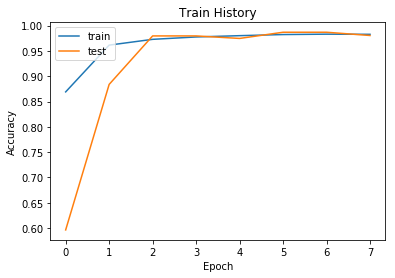

In [190]:
show_train_history('acc','val_acc')

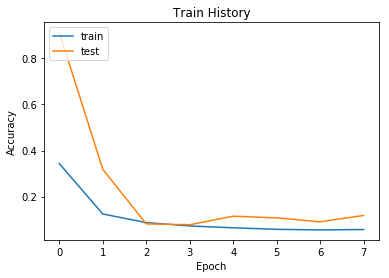

In [191]:
show_train_history('loss','val_loss')

In [192]:
VXcnn = np.expand_dims(VX, axis=2)
VXcnn

scores = model.evaluate(VXcnn, 
                        y_label_test_OneHot, verbose=0)
scores[1]

0.9868421052631579

In [389]:
ValidPrediction=model.predict_classes(VXcnn)

In [391]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print("Accuracy:%.2f" %accuracy_score(Vycnn,ValidPrediction))
print('MSE test: %.3f' % (
        mean_squared_error(Vycnn, ValidPrediction)))
print('R^2 tset: %.3f' % (
        r2_score(Vycnn, ValidPrediction)))

Accuracy:0.99
MSE test: 0.026
R^2 tset: -2.027


In [195]:
pd.crosstab(Vy.reshape(-1),prediction)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:878: FutureWarning: reshape is deprecated and will raise in a subsequent release
  return self._values.reshape(shape, **kwargs)


col_0,0,1,2
row_0,,,
0,224,1,1
1,0,1,1
2,0,0,0
3,0,0,0


In [196]:
for layer in model.layers:
    weights = layer.get_weights() # list of n
weights

[array([[ 0.2415359 ,  0.13356444, -0.5310829 ,  0.11751797],
        [-0.0265397 ,  0.00986385,  0.06189382, -0.14783418],
        [-0.27325124, -0.24617217,  0.07510055,  0.06320865],
        ...,
        [-0.01286331,  0.09307294, -0.03464985, -0.27372977],
        [ 0.02162831,  0.01591734, -0.17098896,  0.1753083 ],
        [-0.01727616, -0.26157618, -0.08091214,  0.1830286 ]],
       dtype=float32),
 array([-0.31707504,  0.36075175,  0.25445685, -0.45838526], dtype=float32)]

In [197]:
model.get_config()

[{'class_name': 'Conv1D',
  'config': {'activation': 'relu',
   'activity_regularizer': None,
   'batch_input_shape': (None, 527, 1),
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'dilation_rate': (1,),
   'dtype': 'float32',
   'filters': 30,
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'distribution': 'uniform',
     'mode': 'fan_avg',
     'scale': 1.0,
     'seed': None}},
   'kernel_regularizer': None,
   'kernel_size': (30,),
   'name': 'conv1d_17',
   'padding': 'same',
   'strides': (1,),
   'trainable': True,
   'use_bias': True}},
 {'class_name': 'Dropout',
  'config': {'name': 'dropout_25',
   'noise_shape': None,
   'rate': 0.25,
   'seed': None,
   'trainable': True}},
 {'class_name': 'Conv1D',
  'config': {'activation': 'relu',
   'activity_regularizer': None,
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'conf

##################轉換成MONGODB可以存取的格式######################

In [448]:
with open("Events_eps0.7_5days_500topics","rb") as fp:
    Events = pickle.load(fp)

In [418]:
# valid
with open("Valid_events_eps0.7_5days_500topics","rb") as fp:
    Valid_events = pickle.load(fp)

In [457]:
Xforadding = np.expand_dims(X, axis=2)
# Xforadding = np.expand_dims(VX, axis=2)

In [458]:
Events.head(3)

,_id,diff,dmax,dmin,org_indexes,subtag,tag,hundred_billion,hundred_million,ten_million,...,topic_490,topic_491,topic_492,topic_493,topic_494,topic_495,topic_496,topic_497,topic_498,topic_499
0,"{'tag': 0, 'subtag': 2}",3,2017-03-15,2017-02-14,"[20811, 20802, 20779, 18617, 701, 723, 641, 20...",2,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.0000,0.0,0.0,0.000000,0.000000,0.000000
1,"{'tag': 34, 'subtag': 3}",3,2017-07-15,2017-06-21,"[21170, 21157, 1362, 1439, 1361, 1321, 19213, ...",3,34,0,1,0,...,0.0,0.0,0.042339,0.0,0.0000,0.0,0.0,0.000000,0.121955,0.022048
2,"{'tag': 34, 'subtag': 0}",3,2017-05-18,2017-04-27,"[1101, 1054, 1117, 18992, 1147, 18898, 1051, 1...",0,34,1,0,0,...,0.0,0.0,0.000000,0.0,0.0604,0.0,0.0,0.140847,0.000000,0.157387


In [459]:
ValidEvents.head(3)

,_id,diff,dmax,dmin,org_indexes,subtag,tag,hundred_billion,hundred_million,ten_million,...,topic_490,topic_491,topic_492,topic_493,topic_494,topic_495,topic_496,topic_497,topic_498,topic_499
0,"{'tag': 0, 'subtag': 0}",5.0,2018-01-11,2018-01-06,"[204, 187, 180, 225, 159, 179, 167, 175]",0,0,0,0,0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0,0.0
1,"{'tag': 1, 'subtag': 0}",3.0,2018-01-08,2018-01-05,"[164, 163, 298, 157]",0,1,0,0,0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0,0.0
2,"{'tag': 2, 'subtag': 0}",0.0,2017-12-14,2017-12-14,"[297, 296, 295, 294, 293, 292, 291, 290, 289, ...",0,2,0,0,0,...,0.039904,0.0,0.070016,0.233605,0.296288,0.473128,0,0.167313,0,0.0


In [460]:
addingprediction=model.predict_classes(Xforadding)

In [461]:
len(addingprediction)

20806

In [462]:
Events.insert(loc=1, column='prediction', value=addingprediction)
# Valid_events.insert(loc=1, column='prediction', value=addingprediction)

In [463]:

with open('news_all_important_noun',"rb") as f:
        news_important_noun = pickle.load(f)

# with open('Valid_news_all_important_noun',"rb") as f:
#         Valid_news_important_noun = pickle.load(f)

def NameAdd(Events,important_noun):
    Eventsreduce = Events.iloc[:,:33]
    Eventsreduce.insert(loc=0, column="events_Name", value="")  
    
    ENS = []
#     from  sklearn.feature_extraction.text  import  CountVectorizer  
#     vectorizer = CountVectorizer()  
#     X = vectorizer.fit_transform(important_noun)
#     words = vectorizer.get_feature_names()  

#     from  sklearn.feature_extraction.text  import  TfidfTransformer  

#     transformer = TfidfTransformer()  
#     tfidf = transformer.fit_transform(X)
#     w = np.array(words)
    
#     list_h = []
#     for iii in tfidf :
#         tuples = sorted( zip(w, iii.toarray()[0]), key = lambda x : x[1], reverse=True  )
#         article_impword = []
#         for i in tuples[:10]:
#             article_impword.append(i[0])
            
            
#         list_h.append(article_impword)


    for j in range(len(Events["diff"])):
        EN = []
        for i in (Events["org_indexes"][j]):
            EN.append(list_h[i])
        ENS.append( " ".join(str(x) for x in EN[0][:5]))
    
    Eventsreduce["events_Name"]=ENS
    return Eventsreduce
#     print(ENS)

# ValidEventsreduce = NameAdd(Valid_events,Valid_news_important_noun)
Eventsreduce = NameAdd(Events,news_important_noun)
        

       

In [464]:
Eventsreduce

,events_Name,_id,prediction,diff,dmax,dmin,org_indexes,subtag,tag,hundred_billion,...,馬英九,賴清德,洪慈庸,朱立倫,林昶佐,陳菊,李錫錕,丁守中,林佳龍,蔣萬安
0,司法 法官 行政法院 同情心 利用,"{'tag': 0, 'subtag': 2}",3,3,2017-03-15,2017-02-14,"[20811, 20802, 20779, 18617, 701, 723, 641, 20...",2,0,0,...,1,0,0,1,0,0,0,0,0,0
1,杯葛 前瞻 程序 立院 效力,"{'tag': 34, 'subtag': 3}",3,3,2017-07-15,2017-06-21,"[21170, 21157, 1362, 1439, 1361, 1321, 19213, ...",3,34,0,...,0,0,0,1,0,0,0,0,0,0
2,前瞻 杯葛 顏則 人工湖 中央,"{'tag': 34, 'subtag': 0}",3,3,2017-05-18,2017-04-27,"[1101, 1054, 1117, 18992, 1147, 18898, 1051, 1...",0,34,1,...,1,1,0,1,0,1,0,0,1,1
3,教育部 整理 照片 交通 七巧板,"{'tag': 32, 'subtag': 2}",3,3,2015-08-11,2015-07-25,"[6786, 6640, 6633, 6693, 6597, 6674, 6627, 665...",2,32,0,...,0,1,0,0,0,1,0,0,0,0
4,食品 行政院 政府 黑衣 程序,"{'tag': 9, 'subtag': 1}",2,2,2016-12-11,2016-11-26,"[18119, 18103, 18041, 18035, 188, 18047, 193, ...",1,9,0,...,1,0,0,0,0,0,0,0,0,0
5,公司 爆料 破格 注目 去函,"{'tag': 73, 'subtag': 3}",2,2,2015-09-25,2015-09-11,"[7233, 7204, 7061, 7175, 7076, 7106, 7159]",3,73,0,...,0,0,0,0,0,0,0,0,0,0
6,味全 葡萄 配方 油品 成本,"{'tag': 97, 'subtag': 0}",2,2,2014-10-22,2014-10-09,"[4352, 4339, 4262, 4261, 4249, 4212, 4182, 414...",0,97,0,...,0,0,0,0,0,0,0,0,0,0
7,台商 精神科 心理 事宜 行政院,"{'tag': 39, 'subtag': 0}",2,2,2014-05-28,2014-05-15,"[11651, 3040, 3067, 3032, 3064, 3087, 3080, 30...",0,39,0,...,1,0,0,0,0,0,0,0,0,0
8,禁食 住院 物品 祭祖 清空,"{'tag': 78, 'subtag': 0}",2,2,2014-05-03,2014-04-21,"[20623, 11356, 2966, 11423, 2934, 2831, 2864, ...",0,78,0,...,1,1,0,0,0,1,0,0,0,0
9,制度 年金 公教 利率 政府,"{'tag': 8, 'subtag': 2}",2,2,2017-01-30,2017-01-20,"[18350, 447, 463, 584, 499]",2,8,0,...,0,0,0,0,0,0,0,0,0,0


In [465]:
def DataframeReform(Eventsreduce):    
    PNames=[("姚文智","1380211668909443"),("蔡正元", "184799244894343"),("侯友宜","261813197541354"),
     ("盧秀燕","109391162488374"),("江啟臣","191690867518507"),("陳其邁","122936517768637"),
     ("鄭文燦","333058400178329"),("蔡英文","46251501064"),("柯文哲","136845026417486"),
     ("黃國昌","449664581882455"),("馬英九","118250504903757"),("賴清德","152472278103133"),
    ("洪慈庸","852926604746233"),("朱立倫","10150145806225128"), ("林昶佐","365320250345879"), 
     ("陳菊","232716627404"),("李錫錕","360151611020961"), ("丁守中","600540963315152"),
     ("林佳龍","153819538009272"),("蔣萬安","805460986214082")]
    frames = []
    Eventsreduce.drop(["_id"], axis = 1, inplace = True)
    Eventsreduce.insert(loc=0, column="politician_Name", value="")
    Eventsreduce.insert(loc=0, column="politician_id", value="")

    for i in PNames:
        NameEventsTemp = Eventsreduce[Eventsreduce[i[0]]==1]
        NameEventsTemp = NameEventsTemp.iloc[:,0:6]
        NameEventsTemp["politician_Name"] = i[0]
        NameEventsTemp["politician_id"] = i[1]


        frames.append(NameEventsTemp)
    NameEvents = pd.concat(frames)
    return(NameEvents)

# ValidNameEvents = DataframeReform(ValidEventsreduce)
NameEvents = DataframeReform(Eventsreduce)


In [466]:
with open("Politician_and_Events","wb") as f:
    pickle.dump(NameEvents,f)



In [435]:
with open("Valid_Politician_and_Events","wb") as f:
    pickle.dump(ValidNameEvents,f)

In [471]:
ValidNameEvents.head(1)

,politician_id,politician_Name,events_Name,prediction,diff,dmax
21,1380211668909443,姚文智,地方 代表 任由 對手 局面,0,0.0,2017-12-17


In [470]:
NameEvents.head(1)

,politician_id,politician_Name,events_Name,prediction,diff,dmax
144,1380211668909443,姚文智,政策 看板 外界 七巧板 七律,1,1,2015-04-29


In [485]:
frames=[NameEvents,ValidNameEvents]
TotalNameEvents = pd.concat(frames)

In [486]:
TotalNameEvents = TotalNameEvents.rename(index=str, columns={"dmax": "created_time", "events_Name": "events_name","politician_Name":"politician_name"})
TotalNameEvents["diff"] =  TotalNameEvents["diff"].astype('int', copy=False)+1

In [487]:
TotalNameEvents.head(1)

,politician_id,politician_name,events_name,prediction,diff,created_time
144,1380211668909443,姚文智,政策 看板 外界 七巧板 七律,1,2,2015-04-29


In [2]:
with open("Total_Politician_and_Events","rb") as f:
    TotalNameEvents = pickle.load(f)
#     pickle.dump(TotalNameEvents,f)


In [32]:
ForPlot = TotalNameEvents.sort_values(by='created_time', ascending=False).head(200)

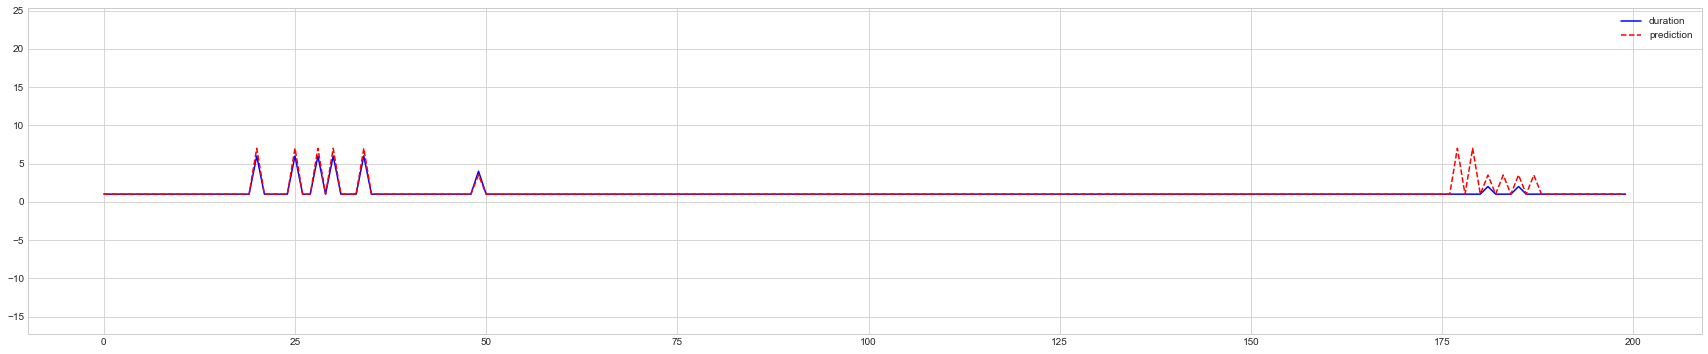

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid') #預設作圖樣式
fig = plt.figure(figsize=(30, 6)) #(an instance of the class plt.Figure) 
#contains all the objects representing axes, graphics, text, and labels.
ax = plt.axes()


diff = np.array(ForPlot["diff"])
prediction = np.array(ForPlot["prediction"])*3.5
for i in range(len(prediction)):
    if prediction[i]==0:
        prediction[i]+=1
# fig, ax = plt.subplots()
x = range(200)
ax.plot(x, diff, '-b', label='duration')
ax.plot(x, prediction, '--r', label='prediction')
ax.axis('equal')
leg = ax.legend();